# Inference of Jones scalars observables (noisy angular quantities)


This is a simple physics model where our data, $y$, is modelled as the principle argument of a unitary complexy vector with white noise added, i.e. the phase of a complex RV, $\phi_\nu = K \tau \nu^{-1} + M \eta \nu + \epsilon$

$L(x) = p(y | x) = \mathcal{N}[y \mid \phi_{\rm obs},\sigma^2 \mathbf{I}]$

where $\phi_{\rm obs} = \arg Y$ and $Y \sim \mathcal{N}(e^{i \phi}, \sigma^2 \mathbf{I}_{\mathbb{C}})$

and we take the priors,

$p(\tau) = \mathcal{C}[\tau \mid 0, 100]$ (Cauchy)


$p(\eta) = \mathcal{U}[\eta \mid -2, 2]$ (Uniform)


$p(\epsilon) = \mathcal{U}[\epsilon \mid -\pi, \pi]$ (Uniform)


$p(\sigma) = \mathcal{HN}[\sigma \mid 0.5]$ (Half-Normal)


In [1]:


import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import DefaultNestedSampler
from jaxns import bruteforce_evidence

tfpd = tfp.distributions


INFO[2023-12-11 02:14:11,009]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 02:14:11,010]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 02:14:11,011]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2023-12-11 02:14:11,011]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:

TEC_CONV = -8.4479745  #rad*MHz/mTECU
CLOCK_CONV = (2e-3 * jnp.pi)  #rad/MHz/ns


def wrap(phi):
    return (phi + jnp.pi) % (2 * jnp.pi) - jnp.pi


def generate_data(key, uncert):
    """
    Generate gain data where the phase have a clock const and tec component. This is a model of the impact of the ionosphere on the propagation of radio waves, part of radio interferometry:

    phase[:] = tec * (tec_conv / freqs[:]) + clock * (clock_conv * freqs[:]) + const

    then the gains are:

        gains[:] ~ Normal[{cos(phase[:]), sin(phase[:])}, uncert^2 * I]

    phase_obs[:] = ArcTan[gains.imag, gains.real]

    Args:
        key:
        uncert: uncertainty of the gains

    Returns:
        phase_obs, freqs
    """
    freqs = jnp.linspace(121, 166, 24)  #MHz
    tec = 90.  #mTECU
    const = 2.  #rad
    clock = 0.5  #ns
    phase = wrap(tec * (TEC_CONV / freqs) + clock * (CLOCK_CONV * freqs) + const)
    Y = jnp.concatenate([jnp.cos(phase), jnp.sin(phase)], axis=-1)
    Y_obs = Y + uncert * random.normal(key, shape=Y.shape)
    phase_obs = jnp.arctan2(Y_obs[..., freqs.size:], Y_obs[..., :freqs.size])
    return phase, phase_obs, freqs


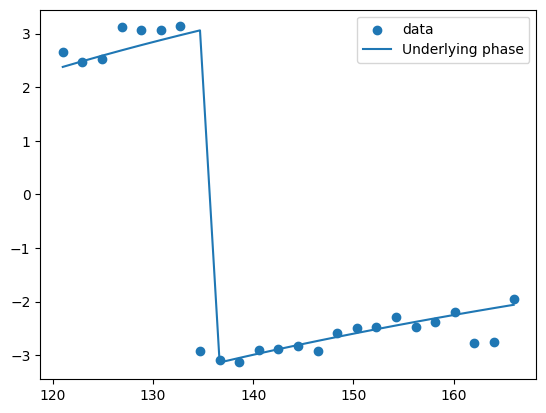

In [3]:
# Generate data
key = random.PRNGKey(43)
key, data_key = random.split(key)
phase_underlying, phase_obs, freqs = generate_data(data_key, 0.25)
plt.scatter(freqs, phase_obs, label='data')
plt.plot(freqs, phase_underlying, label='Underlying phase')
plt.legend()
plt.show()
# Note: the phase wrapping makes this a difficult problem to solve. As we'll see, the posterior is rather complicated.

In [4]:

from jaxns import Prior, Model


def log_normal(x, mean, scale):
    dx = (x - mean) / scale
    return -0.5 * jnp.log(2. * jnp.pi) - jnp.log(scale) - 0.5 * dx * dx


def log_likelihood(tec, const, clock, uncert):
    phase = tec * (TEC_CONV / freqs) + const + clock * (CLOCK_CONV * freqs)
    logL = log_normal(wrap(wrap(phase) - wrap(phase_obs)), 0., uncert)
    return jnp.sum(logL)


def prior_model():
    tec = yield Prior(tfpd.Cauchy(0., 100.), name='tec')
    const = yield Prior(tfpd.Uniform(-jnp.pi, jnp.pi), name='const')
    clock = yield Prior(tfpd.Uniform(-2., 2.), name='clock')
    uncert = yield Prior(tfpd.HalfNormal(0.5), name='uncert')

    return tec, const, clock, uncert


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

log_Z_true = bruteforce_evidence(model=model, S=80)
print(f"True log(Z)={log_Z_true}")

INFO[2023-12-11 02:14:12,314]: Sanity check...
INFO[2023-12-11 02:14:12,766]: Sanity check passed


True log(Z)=-4.638492584228516


In [5]:


# Create the nested sampler class. In this case without any tuning.
ns = exact_ns = DefaultNestedSampler(model=model, num_live_points=model.U_ndims * 128, max_samples=1e5)

termination_reason, state = exact_ns(random.PRNGKey(42))
results = exact_ns.to_results(termination_reason=termination_reason, state=state)


/home/albert/git/jaxns/jaxns/internals/shrinkage_statistics.py:96: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  w_init = (init, jnp.asarray(0, jnp.int_), output)
/home/albert/git/jaxns/jaxns/internals/shrinkage_statistics.py:96: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  w_init = (init, jnp.asarray(0, jnp.int_), output)
/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inpu

In [6]:
# We can use the summary utility to display results
exact_ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 253618
samples: 8330
phantom samples: 5100.0
likelihood evals / sample: 30.4
phantom fraction (%): 61.2%
--------
logZ=-4.78 +- 0.17
H=49.0
ESS=1267.6563720703125
--------
clock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
clock: 0.1 +- 1.0 | -1.0 / -0.2 / 1.6 | -0.7 | -2.0
--------
const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
const: 1.0 +- 1.8 | -1.7 / 1.5 / 3.0 | 2.8 | -1.2
--------
tec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
tec: 72.0 +- 17.0 | 47.0 / 77.0 / 89.0 | 85.0 | 104.0
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.218 +- 0.034 | 0.177 / 0.215 / 0.262 | 0.196 | 0.196
--------


WARNING[2023-12-11 02:14:25,523]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


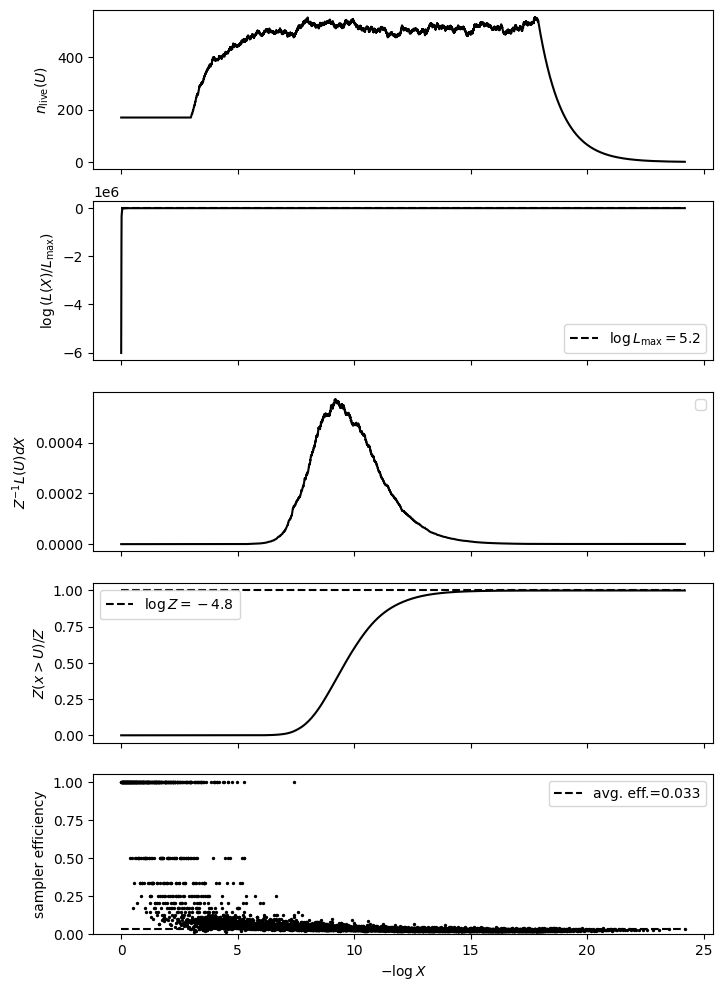

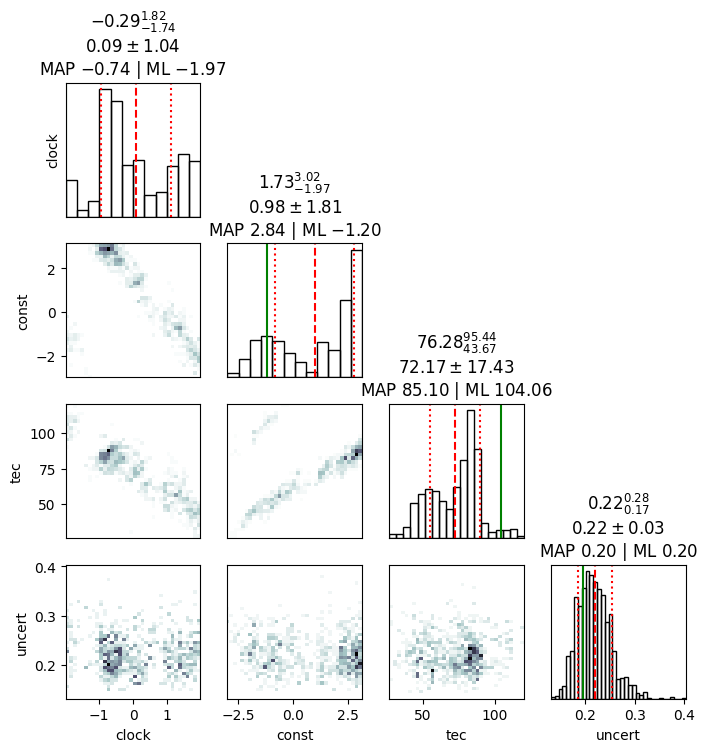

In [7]:
# Finally let's look at the results.
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)

# We can see that the sampler focused more on the initial part of the enclosed prior volume when -logX < 7.5.
# This is evident in the increased n_live points.